In [2]:
!pip install py-cdhit

In [372]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import numpy as np
from NegativeClassOptimization import config
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from NegativeClassOptimization.preprocessing import *

In [555]:
from scipy.stats import pearsonr

In [2]:
from pycdhit import cd_hit, read_fasta, read_clstr, CDHIT

In [3]:
cdhit = CDHIT(prog="cd-hit", path="/Users/aygulminnegalieva/Music/nco/negative-class-optimization/cdhit-master/")
cdhit.help()

		====== CD-HIT version 4.8.1 (built on Nov 16 2023) ======

Usage: /Users/aygulminnegalieva/Music/nco/negative-class-optimization/cdhit-master/cd-hit [Options] 

Options

   -i	input filename in fasta format, required, can be in .gz format
   -o	output filename, required
   -c	sequence identity threshold, default 0.9
 	this is the default cd-hit's "global sequence identity" calculated as:
 	number of identical amino acids or bases in alignment
 	divided by the full length of the shorter sequence
   -G	use global sequence identity, default 1
 	if set to 0, then use local sequence identity, calculated as :
 	number of identical amino acids or bases in alignment
 	divided by the length of the alignment
 	NOTE!!! don't use -G 0 unless you use alignment coverage controls
 	see options -aL, -AL, -aS, -AS
   -b	band_width of alignment, default 20
   -M	memory limit (in MB) for the program, default 800; 0 for unlimitted;
   -T	number of threads, default 1; with 0, all CPUs will be used
   -n	

In [4]:
task_2_folder = {'vs 9':'1v9', 'vs Non-binder':'high_vs_95low', 'vs Weak': 'high_vs_looser', 'vs 1':'1v1'}

In [1]:
def get_train_test_data(ag, task,  split):
    """
    Loads train and test data corresponding to a specific tasks, seed and split. 
    Merges into one dataframe.
    """
    test_path = glob.glob(f'./torch_models/Frozen_MiniAbsolut_ML/{task_2_folder[task]}/seed_0/split_{split}/{ag}*/*_test_dataset.tsv')[0]
    train_path = glob.glob(f'./torch_models/Frozen_MiniAbsolut_ML/{task_2_folder[task]}/seed_0/split_{split}/{ag}*/*_train_dataset.tsv')[0]
    df_test =  pd.read_csv(test_path, sep='\t')
    df_test['Train'] = [False]*df_test.shape[0]
    df_train =  pd.read_csv(train_path, sep='\t')
    df_train['Train'] = [True]*df_train.shape[0]
    df = pd.concat([df_train, df_test])
    df.reset_index(inplace=True)
    df.drop(['Slide_onehot', 'binds_a_pos_ag'], axis=1, inplace=True)
    return df


In [79]:
tasks = ['vs 9', 'vs Non-binder', 'vs Weak'] # also add "vs 1"

In [123]:
def data_leak_cd_hit(ag, identity=0.9):
    #we go over all tasks and al possible seeds and splits
    leak_dict = {'pos':[],
                 'vs 9':[],
                 'vs Non-binder':[],
                 'vs Weak':[]}
    for split in [0,1,2,3,4,42]:
        for task in tasks:
            try:
                df = get_train_test_data(ag, task, 0,split)
                df['fake_id'] = np.arange(df.shape[0])
                df = df.rename(columns={'fake_id': 'identifier','Slide':'sequence'})
                df['identifier'] = df.identifier.astype('str').values
                columns_to_keep = ['identifier', 'cluster', 'is_representative', 'identity']
                _, df_clstr = cdhit.set_options(c=identity, d=0, sc=1).cluster(df[['identifier', 'sequence']]) #writ here what parameters mean
                df = df.merge(df_clstr[columns_to_keep], on=['identifier'])
                leak = quant_inter(df) #sould return dict
                ##leak_dict[task].append(neg_leak)

                #interesting how much positive and negative intersect if 1 aa substitutions turns binder to nonbinder
            except:
                pass

    return leak_dict

def quant_inter(df_clusters):
    set_train = set(df_clusters[df_clusters['Train'] == True].cluster.unique())
    df_test = df_clusters[df_clusters['Train'] == False]
    set_test = set(df_test.cluster.unique())
    #leak_perc = len(set_train.intersection(set_test))/len(set_test)
    inters = set_train.intersection(set_test)
    n_leak = df_test.cluster.isin(inters).sum()
    return n_leak/df_test.shape[0]

#maybe it make sence to save df_clust


In [ ]:
"""

def data_leak_cd_hit(ag, identity=0.9):
    #we go over all tasks and al possible splits
    leak_dict = {'pos':[],
                 'vs 9':[],
                 'vs Non-binder':[],
                 'vs Weak':[]}
    for split in [0,1,2,3,4,42]:
        calc_pos = True
        for task in tasks:
            try:
                df = get_train_test_data(ag, task, split)
                df['fake_id'] = np.arange(df.shape[0])
                df = df.rename(columns={'fake_id': 'identifier','Slide':'sequence'})
                df['identifier'] = df.identifier.astype('str').values
                df_pos = df[df['y'] == 1]
                df_neg = df[df['y'] == 0]
                columns_to_keep = ['identifier', 'cluster', 'is_representative', 'identity']
                if calc_pos:
                    _, df_clstr_pos = cdhit.set_options(c=identity, d=0, sc=1).cluster(df_pos[['identifier', 'sequence']]) #write here what parameters mean
                    df_pos = df_pos.merge(df_clstr_pos[columns_to_keep], on=['identifier'])
                    pos_leak = quant_inter(df_pos)
                    leak_dict['pos'].append(pos_leak)
                _, df_clstr_neg = cdhit.set_options(c=identity, d=0, sc=1).cluster(df_neg[['identifier', 'sequence']]) #write here what parameters mean
                df_neg = df_neg.merge(df_clstr_neg[columns_to_keep], on=['identifier'])
                neg_leak = quant_inter(df_neg)
                leak_dict[task].append(neg_leak)
                calc_pos = False

                #interesting how much positive and negative intersect if 1 aa substitutions turns binder to nonbinder
            except:
                pass

    return leak_dict


def quant_inter(df_clusters):
    #pos
    df_pos = df_clusters[df_clusters['y'] == 1]
    df_neg = df_clusters[df_clusters['y'] == 0]
    set_train_pos = set(df_pos[df_pos['Train'] == True].cluster.unique())
    set_test_pos = set(df_pos[df_pos['Train'] == False].cluster.unique())
    leak_perc_pos = len(set_train_pos.intersection(set_test_pos))/(len(set_train_pos)+len(set_test_pos)) should be union
    #negative
    set_train_neg = set(df_pos[df_heg['Train'] == True].cluster.unique())
    set_test_neg = set(df_pos[df_neg['Train'] == False].cluster.unique())
    leak_perc_neg = len(set_train_neg.intersection(set_test_neg))/(len(set_train_neg)+len(set_test_neg)) should be union
    #between positive and negative
    set_pos = set(df_pos.cluster.unique())
    set_neg = set(df_neg.cluster.unique())
    neg_pos_simmilarity = len(set_neg.intersection(set_pos))/(len(set_neg)+len(set_pos))
    return leak_perc"""

In [124]:
dfs_slide_leak = []
for ag in config.ANTIGENS:
   leak = data_leak_cd_hit(ag) 
   df = pd.DataFrame(leak).melt(var_name='class')
   df['Antigen'] = [ag]*df.shape[0]
   dfs_slide_leak.append(df)

In [125]:
dfs_slide_leak = pd.concat(dfs_slide_leak)

In [127]:
ag_order = [
        "1FBI",
        "3VRL",
        "2YPV",
        "5E94",
        "1WEJ",
        "1OB1",
        "1NSN",
        "1H0D",
        "3RAJ",
        "1ADQ",
    ]

<AxesSubplot:xlabel='Antigen', ylabel='value'>

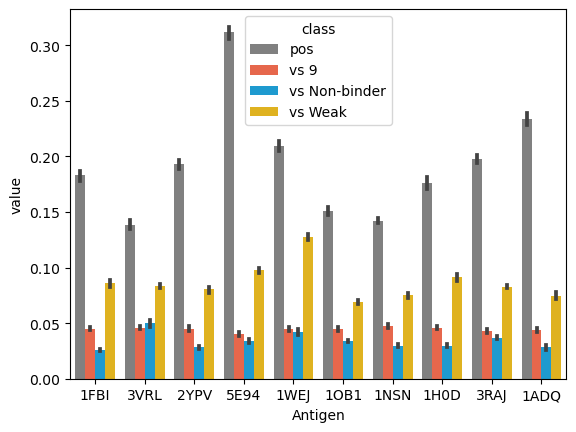

In [128]:
sns.barplot(x='Antigen',y='value',hue='class',data=dfs_slide_leak, palette=cmap, order=ag_order)

In [ ]:
#when switching from train test
#pos that stayed pos
#neg that stayed negative
#pos that became negatives
#negatitives that became pos

#combine train test calculate

In [170]:
def run_cd_hit(ag, task, split, identity=0.9):
    #we go over all tasks and al possible seeds and splits        calc_pos = True
    df = get_train_test_data(ag, task, 0,split)
    df['fake_id'] = np.arange(df.shape[0])
    df = df.rename(columns={'fake_id': 'identifier','Slide':'sequence'})
    df['identifier'] = df.identifier.astype('str').values
    columns_to_keep = ['identifier',	'cluster', 'is_representative',	'identity']
    _, df_clstr = cdhit.set_options(c=identity, d=0, sc=1).cluster(df[['identifier', 'sequence']]) #writ here what parameters mean
    df = df.merge(df_clstr[columns_to_keep], on=['identifier'])
    df = df.drop(['index','X', 'identity'], axis=1)
    return df


In [172]:
for ag in config.ANTIGENS:
    for task in tasks:
        for split in [0,1,2,3,4,42]:
            try:
                df = run_cd_hit(ag, task, split, identity=0.9)
                df.to_csv(f'./cd-hit-res/{ag}__{task}__{split}.csv')
            except IndexError:
                print('No dataset with given characteristics')

In [174]:
print(ag, task, split)

1OB1 vs Weak 42


In [178]:
#clusters in train that also in  pos
pos = df['y']==1
neg = df['y']==0
train = df['Train'] == True
test = df['Train'] == False

In [180]:
pos_pos_leak = set(df[pos & train].cluster.unique()).intersection(set(df[pos & test].cluster.unique()))
neg_neg_leak = set(df[neg & train].cluster.unique()).intersection(set(df[neg & test].cluster.unique()))
pos_neg_leak = set(df[pos & train].cluster.unique()).intersection(set(df[neg & test].cluster.unique()))
neg_pos_leak = set(df[neg & train].cluster.unique()).intersection(set(df[pos & test].cluster.unique()))

In [181]:
print(len(pos_pos_leak), len(neg_neg_leak), len(pos_neg_leak), len(neg_pos_leak))
#now mabe we need to average this per split? or show error bars?

674 306 144 131


In [327]:
def cal_leaks(df):
    pos = df['y']==1
    neg = df['y']==0
    train = df['Train'] == True
    test = df['Train'] == False
    pos_pos_leak = set(df[pos & train].cluster.unique()).intersection(set(df[pos & test].cluster.unique()))
    neg_neg_leak = set(df[neg & train].cluster.unique()).intersection(set(df[neg & test].cluster.unique()))
    pos_neg_leak = set(df[pos & train].cluster.unique()).intersection(set(df[neg & test].cluster.unique()))
    neg_pos_leak = set(df[neg & train].cluster.unique()).intersection(set(df[pos & test].cluster.unique()))
    #we have to quatify how many sequences are in this class
    pos_pos = df[test].cluster.isin(pos_pos_leak).sum()/df[test].shape[0]
    neg_neg = df[test].cluster.isin(neg_neg_leak).sum()/df[test].shape[0]
    pos_neg = df[test].cluster.isin(pos_neg_leak).sum()/df[test].shape[0]
    neg_pos = df[test].cluster.isin(neg_pos_leak).sum()/df[test].shape[0]

    leak_dict = {
        '++': pos_pos_leak,
        '--': neg_neg_leak,
        '+-': pos_neg_leak,
        '-+': neg_pos_leak
    }

    leak_dict_count = {
        '++': pos_pos,
        '--': neg_neg,
        '+-': pos_neg,
        '-+': neg_pos
    }


    return leak_dict, leak_dict_count

In [397]:
ag_order

['1FBI',
 '3VRL',
 '2YPV',
 '5E94',
 '1WEJ',
 '1OB1',
 '1NSN',
 '1H0D',
 '3RAJ',
 '1ADQ']

In [402]:
#lets plot for one task, all abs
task = 'vs Non-binder'
split = 42
ag_nb_leaks = dict()
for ag in config.ANTIGENS:
    df = pd.read_csv(f'./cd-hit-res/{ag}__{task}__{split}.csv')
    _, leak_dict_count = cal_leaks(df)
    ag_nb_leaks[ag] = leak_dict_count

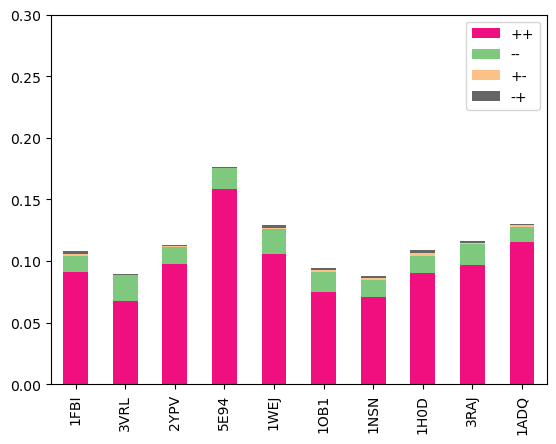

In [627]:
pd.DataFrame.from_dict(ag_nb_leaks,orient='index').loc[ag_order].plot(kind='bar', stacked=True, ylim=(0,0.3), color=["#F00F7F", "#7FC97F", "#FDC086","#666666"])
plt.savefig('./figures/leak_90%_non-binder.svg')

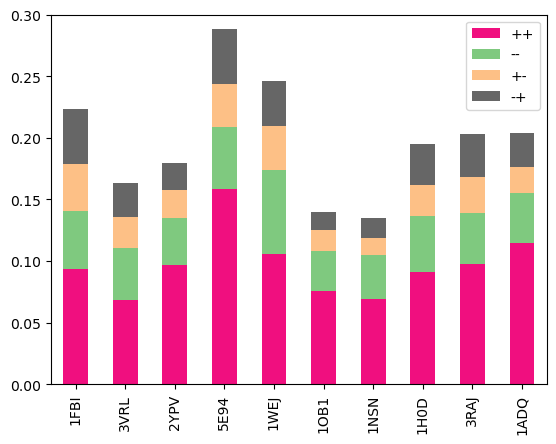

In [626]:
#lets plot for one task, all abs
task = 'vs Weak'
split = 42
ag_wk_leaks = dict()
for ag in config.ANTIGENS:
    df = pd.read_csv(f'./cd-hit-res/{ag}__{task}__{split}.csv')
    _, leak_dict_count = cal_leaks(df)
    ag_wk_leaks[ag] = leak_dict_count
pd.DataFrame.from_dict(ag_wk_leaks,orient='index').loc[ag_order].plot(kind='bar', stacked=True, ylim=(0,0.3), color=["#F00F7F", "#7FC97F", "#FDC086","#666666"])
#={"++": "#F00F7F", "--": "#7FC97F","+-": "#FDC086","-+":"#666666"}
# ["#F00F7F", "#7FC97F", "#FDC086","#666666"]
plt.savefig('./figures/leak_90%_weak.svg')


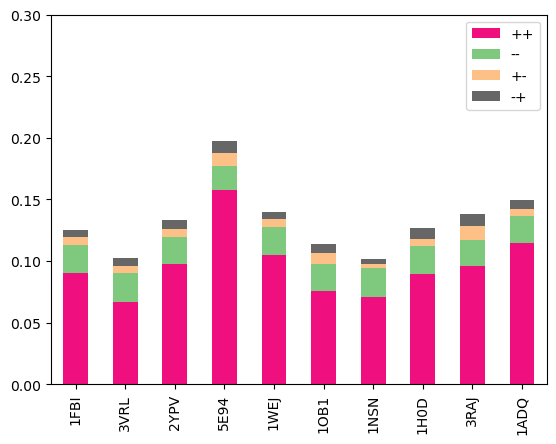

In [628]:
#lets plot for one task, all abs
task = 'vs 9'
split = 42
ag_v9_leaks = dict()
for ag in config.ANTIGENS:
    df = pd.read_csv(f'./cd-hit-res/{ag}__{task}__{split}.csv')
    _, leak_dict_count = cal_leaks(df)
    ag_v9_leaks[ag] = leak_dict_count
pd.DataFrame.from_dict(ag_v9_leaks,orient='index').loc[ag_order].plot(kind='bar', stacked=True, ylim=(0,0.3), color=["#F00F7F", "#7FC97F", "#FDC086","#666666"])
plt.savefig('./figures/leak_90%_vs9.svg')

In [712]:
df

,Unnamed: 0,sequence,y,Train,identifier,cluster,is_representative
0,0,AADLSLYFDYW,1,True,0,25205,True
1,1,AAFGLLNYYAM,1,True,1,25204,True
2,2,AAGLLRFAWFA,0,True,2,25207,True
3,3,AAGLLRLYYYA,0,True,3,25206,True
4,4,AAGLRLYFDYW,1,True,4,217,True
...,...,...,...,...,...,...,...
39984,39984,YYYGSLFYFDY,1,False,39984,2461,False
39985,39985,YYYGSSFYVLF,0,False,39985,13204,True
39986,39986,YYYGSSLTLFA,0,False,39986,13207,True
39987,39987,YYYGTLFYFDV,1,False,39987,13206,True


In [713]:
cluster_leaks, _ = cal_leaks(df)

In [718]:
cluster_leaks['++'].intersection(cluster_leaks['-+'])

{19, 23, 47, 59, 111, 141, 231, 258, 301, 367}

In [719]:
cluster_leaks = pd.DataFrame([(key, val) for key, vals in cluster_leaks.items() for val in vals], columns=['Type of leak', 'cluster'])


In [721]:
cluster_leaks.cluster.value_counts()

59      4
141     2
282     2
345     2
366     2
       ..
116     1
584     1
587     1
588     1
1530    1
Name: cluster, Length: 1047, dtype: int64

In [537]:
def cal_leak_energy_std(task, split):
    leaks_eng_std = []
    for ag in config.ANTIGENS:
        df = pd.read_csv(f'./cd-hit-res/{ag}__{task}__{split}.csv')
        cluster_leaks, _ = cal_leaks(df)
        cluster_leaks = pd.DataFrame([(key, val) for key, vals in cluster_leaks.items() for val in vals], columns=['Type of leak', 'cluster'])
        #combine with energy data
        path_pos = glob.glob(f'../data/full_data/divided2classes/{ag}*/{ag}_[A-Z]_MascotteSlices.txt')[0]
        if task == 'vs 9':
            paths_neg = glob.glob(f'../data/full_data/divided2classes/[^{ag}]*/*_MascotteSlices.txt')
            neg_engs = []
            for path in paths_neg:
                neg_eng = pd.read_csv(path,  sep='\t', header=1)[['ID_slide_Variant', 'Slide', 'Energy']]
                neg_engs.append(neg_eng)
            neg_engs = pd.concat(neg_engs)
            eng_df = pd.concat([pos_eng, neg_engs])
        else:
            path_neg = glob.glob(f'../data/full_data/divided2classes/{ag}*/{ag}_[A-Z]_500kNonMascotte.txt')[0]
            path_loose = glob.glob(f'../data/full_data/divided2classes/{ag}*/{ag}_[A-Z]_LooserExclusiveSlices.txt')[0]
            pos_eng = pd.read_csv(path_pos, sep='\t', header=1)[['ID_slide_Variant', 'Slide', 'Energy']]
            neg_eng = pd.read_csv(path_neg,  sep='\t', header=1)[['ID_slide_Variant', 'Slide', 'Energy']]
            wk_eng = pd.read_csv(path_loose,  sep='\t', header=1)[['ID_slide_Variant', 'Slide', 'Energy']]
            eng_df = pd.concat([pos_eng, neg_eng, wk_eng])
        df = df.merge(eng_df,left_on='sequence', right_on='Slide', how='left')

        df_stats = df.groupby('cluster').Energy.describe()
        df_stats = df_stats.reset_index().merge(cluster_leaks, on='cluster', how='left')
        #ab_clusters_sd[ag] = df_stats['std'].dropna().values
        df_stats['Type of leak'] = df_stats['Type of leak'].fillna('only in train/test')
        df_stats['Antigen'] = ag
        leaks_eng_std.append(df_stats)
    df_leaks_eng_std = pd.concat(leaks_eng_std)
    return df_leaks_eng_std

#do the same for vs 9

In [539]:
vs9_leaks_eng_std = cal_leak_energy_std('vs 9', 42)

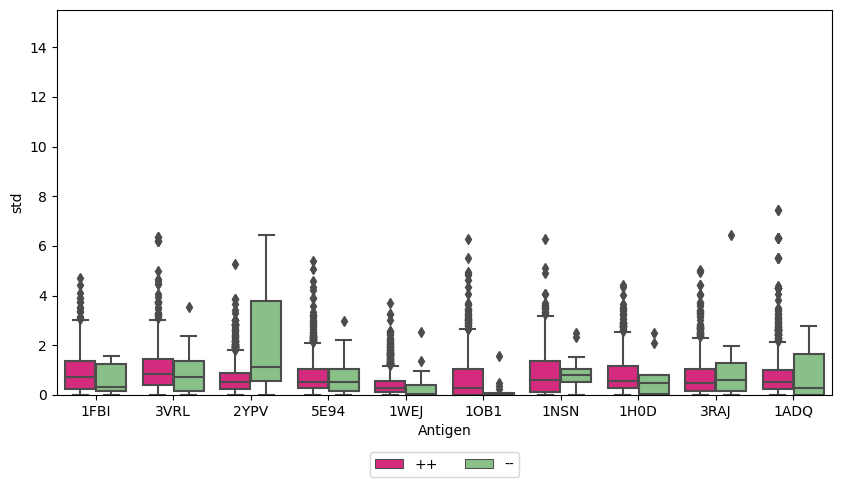

In [629]:
plt.figure(figsize=(10, 5))
plt.ylim([0,15.5])
sns.boxplot(vs9_leaks_eng_std, x='Antigen', y='std', hue='Type of leak', hue_order=['++', '--'], order=ag_order, palette={"++": "#F00F7F", "--": "#7FC97F","+-": "#FDC086","-+":"#666666"})
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.13), ncol=5)
plt.savefig('./figures/leak_energy_vs9.svg')

In [528]:
split = 42
nb_leaks_eng_std = cal_leak_energy_std('vs Non-binder', split)
wk_leaks_eng_std = cal_leak_energy_std('vs Weak', split)

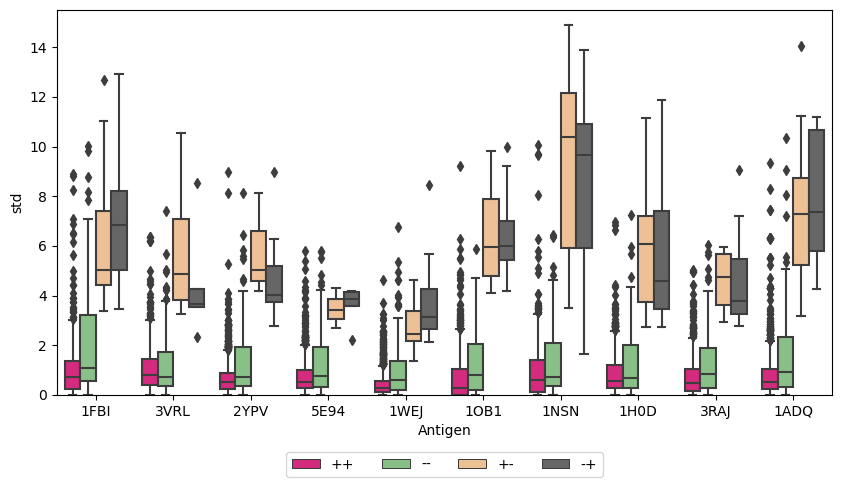

In [630]:
plt.figure(figsize=(10, 5))
plt.ylim([0,15.5])
sns.boxplot(nb_leaks_eng_std, x='Antigen', y='std', hue='Type of leak', hue_order=['++', '--', '+-', '-+'], order=ag_order, palette={"++": "#F00F7F", "--": "#7FC97F","+-": "#FDC086","-+":"#666666"})
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.13), ncol=5)
plt.savefig('./figures/leak_energy_non-binder.svg')

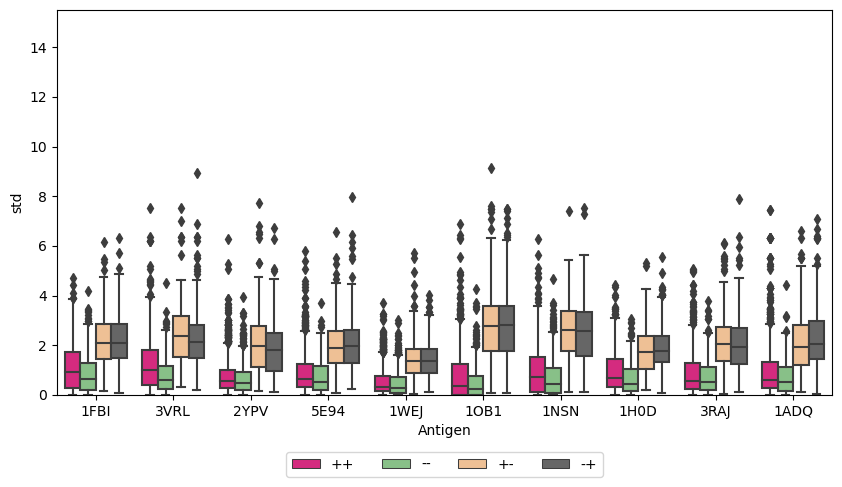

In [631]:
plt.figure(figsize=(10, 5))
plt.ylim([0,15.5])
sns.boxplot(wk_leaks_eng_std, x='Antigen', y='std', hue='Type of leak', hue_order=['++', '--', '+-', '-+'], order=ag_order, palette={"++": "#F00F7F", "--": "#7FC97F","+-": "#FDC086","-+":"#666666"})
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.13), ncol=5)
plt.savefig('./figures/leak_energy_weak.svg')

In [462]:
##How leak correlates with performance?
perf_df = pd.read_csv('../data/openset_performance.tsv', sep='\t')
perf_df = pd.read_csv('../data/openset_performance.tsv', sep='\t')
perf_df[['train_task', 'train_ag', 'train_neg', 'seed_id', 'split_id']] = perf_df.task_1.str.split('__', expand=True)
perf_df[['test_task', 'test_ag', 'test_neg', 'test_seed_id', 'test_split_id']] = perf_df.task_2.str.split('__', expand=True)
perf_df.drop(['task_1', 'task_2'], inplace=True, axis=1)
task_rename = {'ONE_VS_NINE': 'vs 9', 'HIGH_VS_95LOW': 'vs Non-binder', 'HIGH_VS_LOOSER': 'vs Weak'}
perf_df['train_task'] = perf_df['train_task'].apply(lambda x: task_rename[x])
perf_df['test_task'] = perf_df['test_task'].apply(lambda x: task_rename[x])

In [466]:
perf_closed = perf_df[perf_df['train_task'] == perf_df['test_task']]

In [545]:
def leak_perf_corr(task, split, leaks_eng_std, std_cut_off=1 ):
    true_leak = dict()
    for ag in config.ANTIGENS:
        df = pd.read_csv(f'./cd-hit-res/{ag}__{task}__{split}.csv')
        ag_target = leaks_eng_std['Antigen'] == ag
        same_label = leaks_eng_std['Type of leak'].isin(['++', '--'])
        small_std = leaks_eng_std['std'] <= std_cut_off
        true_leak_clusters = leaks_eng_std[ag_target & same_label & small_std]['cluster'].values
        leak_size = df[(df['Train'] == False) & df['cluster'].isin(true_leak_clusters)].shape[0]
        leak_ratio = leak_size/df[(df['Train'] == False)].shape[0]
        true_leak[ag] = leak_ratio
    leak_ratios_df = pd.DataFrame.from_dict(true_leak, orient='index', columns=['leak_ratio']).reset_index()
    #getting performances
    task_selection = perf_closed['train_task'] == task
    seed_selection = perf_closed['test_seed_id'] == '0'
    split_selectio = perf_closed['test_split_id'] == str(split)
    perf_task = perf_closed[task_selection & seed_selection & split_selectio][['train_ag', 'acc']]
    perf_leak_df = perf_task.merge(leak_ratios_df, left_on='train_ag', right_on='index')
    return perf_leak_df



In [546]:
task = 'vs Non-binder'
split =42
leaks_eng_std = nb_leaks_eng_std
perf_leak_nb = leak_perf_corr(task, split, leaks_eng_std)

In [681]:
task = 'vs Weak'
split =42
leaks_eng_std = wk_leaks_eng_std
perf_leak_wk = leak_perf_corr(task, split, leaks_eng_std)

task = 'vs 9'
split =42
leaks_eng_std = vs9_leaks_eng_std
perf_leak_vs9 = leak_perf_corr(task, split, leaks_eng_std)

{'vs 9': '#FF5733',
 'vs Non-binder': '#00A6ED',
 'vs Weak': '#FFC300',
 'vs 1': '#8B5F4D',
 'pos': '#808080'}

In [732]:
def corr_to_plot(xs, ys):
    r, pval = pearsonr(xs, ys)
    x_plot = xs.mean()
    y_plot = ys.mean()
    return r, x_plot, y_plot, pval

/var/folders/ww/bptfq9n12_jbyy78qcjp7s4c0000gn/T/ipykernel_31523/3628587618.py:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=perf_leak_nb, x='leak_ratio', y='acc',ax=ax, palette=['#00A6ED'])
/var/folders/ww/bptfq9n12_jbyy78qcjp7s4c0000gn/T/ipykernel_31523/3628587618.py:7: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=perf_leak_wk, x='leak_ratio', y='acc',ax=ax, palette=['#FFC300'])
/var/folders/ww/bptfq9n12_jbyy78qcjp7s4c0000gn/T/ipykernel_31523/3628587618.py:13: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=perf_leak_vs9, x='leak_ratio', y='acc',ax=ax, palette=['#FF5733'])


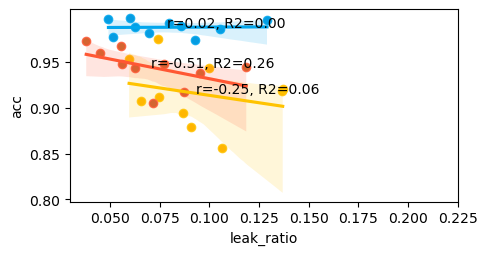

In [734]:
fig, ax = plt.subplots(figsize=(5,2.5))
sns.scatterplot(data=perf_leak_nb, x='leak_ratio', y='acc',ax=ax, palette=['#00A6ED'])
sns.regplot(data=perf_leak_nb, x='leak_ratio', y='acc',ax=ax, color='#00A6ED')
r, x_plot, y_plot, pval = corr_to_plot(perf_leak_nb['leak_ratio'], perf_leak_nb['acc'])
ax.text(x_plot, y_plot, f"r={r:.2f}, R2={r**2:.2f}" , fontsize=10)

sns.scatterplot(data=perf_leak_wk, x='leak_ratio', y='acc',ax=ax, palette=['#FFC300'])
sns.regplot(data=perf_leak_wk, x='leak_ratio', y='acc',ax=ax, color='#FFC300')
r, x_plot, y_plot, pval = corr_to_plot(perf_leak_wk['leak_ratio'], perf_leak_wk['acc'])
ax.text(x_plot, y_plot, f"r={r:.2f}, R2={r**2:.2f}" , fontsize=10)


sns.scatterplot(data=perf_leak_vs9, x='leak_ratio', y='acc',ax=ax, palette=['#FF5733'])
sns.regplot(data=perf_leak_vs9, x='leak_ratio', y='acc',ax=ax, color='#FF5733')
r, x_plot, y_plot, pval = corr_to_plot(perf_leak_vs9['leak_ratio'], perf_leak_vs9['acc'])
ax.text(x_plot, y_plot, f"r={r:.2f}, R2={r**2:.2f}" , fontsize=10)


plt.yticks(np.arange(0.8,1, 0.05)) 
plt.xlim(0.03, 0.225)
fig.savefig('./figures/true_leak_corr.svg')

In [556]:
pearsonr(perf_leak_nb['leak_ratio'], perf_leak_nb['acc'])

(0.02443078422885574, 0.9465895458451709)

In [548]:
"""task = 'vs Weak'
split =42
leaks_eng_std = wk_leaks_eng_std
perf_leak_wk = leak_perf_corr(task, split, leaks_eng_std)"""

In [557]:
pearsonr(perf_leak_wk['leak_ratio'], perf_leak_wk['acc'])

(-0.24804372044856798, 0.4895736157704801)

In [558]:
pearsonr(perf_leak_vs9['leak_ratio'], perf_leak_vs9['acc'])

(-0.5050732094458331, 0.13647891086395045)

In [668]:
def all_leak_perf_corr(task, split, leaks_eng_std, std_cut_off=1 ):
    true_leak = dict()
    for ag in config.ANTIGENS:
        df = pd.read_csv(f'./cd-hit-res/{ag}__{task}__{split}.csv')
        ag_target = leaks_eng_std['Antigen'] == ag
        same_label = leaks_eng_std['Type of leak'].isin(['++', '--'])
        true_leak_clusters = leaks_eng_std[ag_target & same_label]['cluster'].values
        leak_size = df[(df['Train'] == False) & df['cluster'].isin(true_leak_clusters)].shape[0]
        leak_ratio = leak_size/df[(df['Train'] == False)].shape[0]
        true_leak[ag] = leak_ratio
    leak_ratios_df = pd.DataFrame.from_dict(true_leak, orient='index', columns=['leak_ratio']).reset_index()
    #getting performances
    task_selection = perf_closed['train_task'] == task
    seed_selection = perf_closed['test_seed_id'] == '0'
    split_selectio = perf_closed['test_split_id'] == str(split)
    perf_task = perf_closed[task_selection & seed_selection & split_selectio][['train_ag', 'acc']]
    perf_leak_df = perf_task.merge(leak_ratios_df, left_on='train_ag', right_on='index')
    return perf_leak_df

In [669]:
task = 'vs Non-binder'
split =42
leaks_eng_std = nb_leaks_eng_std
perf_all_leak_nb = all_leak_perf_corr(task, split, leaks_eng_std)

In [653]:
task = 'vs Weak'
split =42
leaks_eng_std = wk_leaks_eng_std
perf_all_leak_weak = all_leak_perf_corr(task, split, leaks_eng_std)

In [655]:
task = 'vs 9'
split =42
leaks_eng_std = vs9_leaks_eng_std
perf_all_leak_vs9 = all_leak_perf_corr(task, split, leaks_eng_std)

/var/folders/ww/bptfq9n12_jbyy78qcjp7s4c0000gn/T/ipykernel_31523/1831519930.py:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=perf_all_leak_nb, x='leak_ratio', y='acc',ax=ax, palette=['#00A6ED'])
/var/folders/ww/bptfq9n12_jbyy78qcjp7s4c0000gn/T/ipykernel_31523/1831519930.py:7: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=perf_all_leak_weak, x='leak_ratio', y='acc',ax=ax, palette=['#FFC300'])
/var/folders/ww/bptfq9n12_jbyy78qcjp7s4c0000gn/T/ipykernel_31523/1831519930.py:13: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=perf_all_leak_vs9, x='leak_ratio', y='acc',ax=ax, palette=['#FF5733'])


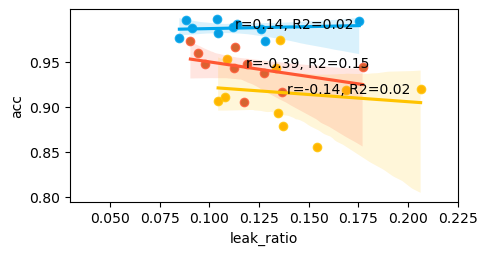

In [731]:
fig, ax = plt.subplots(figsize=(5, 2.5))
sns.scatterplot(data=perf_all_leak_nb, x='leak_ratio', y='acc',ax=ax, palette=['#00A6ED'])
sns.regplot(data=perf_all_leak_nb, x='leak_ratio', y='acc',ax=ax, color='#00A6ED')
r, x_plot, y_plot, pval = corr_to_plot(perf_all_leak_nb['leak_ratio'], perf_all_leak_nb['acc'])
ax.text(x_plot, y_plot, f"r={r:.2f}, R2={r**2:.2f}" , fontsize=10)

sns.scatterplot(data=perf_all_leak_weak, x='leak_ratio', y='acc',ax=ax, palette=['#FFC300'])
sns.regplot(data=perf_all_leak_weak, x='leak_ratio', y='acc',ax=ax, color='#FFC300')
r, x_plot, y_plot, pval = corr_to_plot(perf_all_leak_weak['leak_ratio'], perf_all_leak_weak['acc'])
ax.text(x_plot, y_plot, f"r={r:.2f}, R2={r**2:.2f}" , fontsize=10)


sns.scatterplot(data=perf_all_leak_vs9, x='leak_ratio', y='acc',ax=ax, palette=['#FF5733'])
sns.regplot(data=perf_all_leak_vs9, x='leak_ratio', y='acc',ax=ax, color='#FF5733')
r, x_plot, y_plot, pval = corr_to_plot(perf_all_leak_vs9['leak_ratio'], perf_all_leak_vs9['acc'])
ax.text(x_plot, y_plot, f"r={r:.2f}, R2={r**2:.2f}" , fontsize=10)


plt.yticks(np.arange(0.8,1, 0.05)) 
plt.xlim(0.03, 0.225)

fig.savefig('./figures/all_leak_corr.svg')

In [657]:
task_2TASK = {'vs 9': 'ONE_VS_NINE', 'vs Non-binder': 'HIGH_VS_95LOW', 'vs Weak': 'HIGH_VS_LOOSER'}
tasks_dict = {'ONE_VS_NINE': '1v9', 'HIGH_VS_95LOW': 'high_vs_95low', 'HIGH_VS_LOOSER': 'high_vs_looser'}
task_template = {'ONE_VS_NINE': '{ag}__vs__9', 'HIGH_VS_95LOW': '{ag}_high__vs__{ag}_95low', 'HIGH_VS_LOOSER': '{ag}_high__vs__{ag}_looser'}

In [587]:
def model_mistakes_on_leak(task, seed, split):
    TASK = task_2TASK[task]
    ags_acc_on_leak = []
    for ag in config.ANTIGENS:
        model_path = f"./torch_models/Frozen_MiniAbsolut_ML/{tasks_dict[TASK]}/seed_{seed}/split_{split}/{task_template[TASK].format(ag=ag)}/swa_model/data/model.pth"
        model = torch.load(model_path, map_location=torch.device('cpu'))
        df = pd.read_csv(f'./cd-hit-res/{ag}__{task}__{split}.csv')
        cluster_leaks, _ = cal_leaks(df)
        cluster_leaks = pd.DataFrame([(key, val) for key, vals in cluster_leaks.items() for val in vals], columns=['Type of leak', 'cluster'])
        test = df['Train'] == False
        df_test_leaked = df[test].merge(cluster_leaks, on='cluster')
        df_test_leaked['X'] = df_test_leaked.sequence.apply(onehot_encode)
        X = torch.tensor(np.array(df_test_leaked['X'].tolist()), dtype=torch.float32).to('cpu')
        y_pred = model(X, return_logits = False)
        y_pred = y_pred.cpu().detach().numpy().reshape(-1).round()
        df_test_leaked['y_pred'] = y_pred
        df_test_leaked['correct pred'] = df_test_leaked['y_pred'] ==  df_test_leaked['y']
        acc_on_leak = df_test_leaked.groupby('Type of leak').mean('correct pred')
        acc_on_leak = acc_on_leak.reset_index()[['Type of leak', 'correct pred']]
        acc_on_leak['correct pred'] = acc_on_leak['correct pred'].apply(lambda x: 1-x)
        acc_on_leak.rename(columns={'correct pred':'error rate'}, inplace=True)
        acc_on_leak['ag'] = [ag]*acc_on_leak.shape[0]
        ags_acc_on_leak.append(acc_on_leak)
    ags_acc_on_leak = pd.concat(ags_acc_on_leak)
    return ags_acc_on_leak



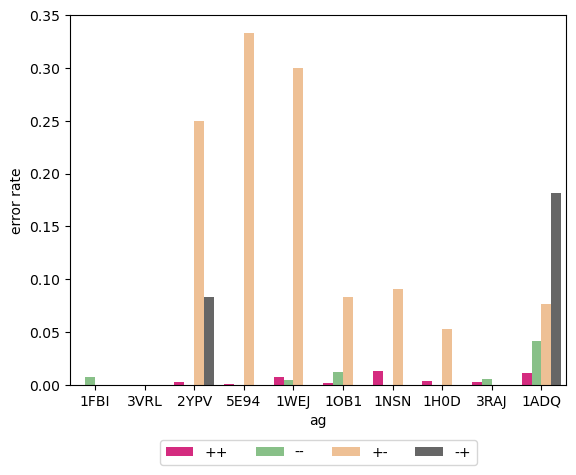

In [658]:
#nb_acc_on_leak = model_mistakes_on_leak('vs Non-binder', 0, 42)
plt.ylim([0,0.35])
sns.barplot(nb_acc_on_leak, x='ag', y='error rate', hue='Type of leak', hue_order=['++', '--', '+-', '-+'], order=ag_order, palette={"++": "#F00F7F", "--": "#7FC97F","+-": "#FDC086","-+":"#666666"})
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.13), ncol=5)
plt.savefig("./figures/leak_error_nb.svg")

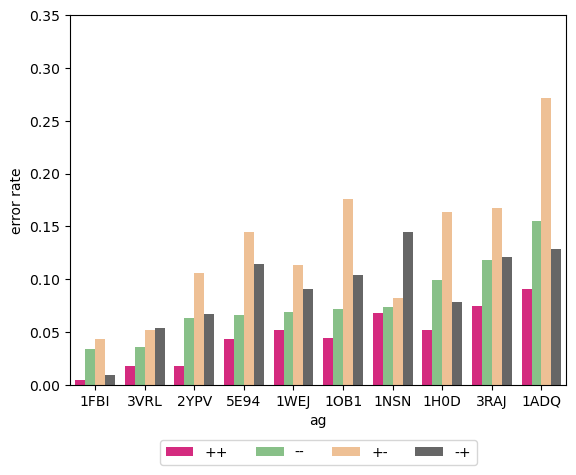

In [659]:
#wk_acc_on_leak = model_mistakes_on_leak('vs Weak', 0, 42)
plt.ylim([0,0.35])
sns.barplot(wk_acc_on_leak, x='ag', y='error rate', hue='Type of leak', hue_order=['++', '--', '+-', '-+'], order=ag_order, palette={"++": "#F00F7F", "--": "#7FC97F","+-": "#FDC086","-+":"#666666"})
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.13), ncol=5)
plt.savefig("./figures/leak_error_wk.svg")

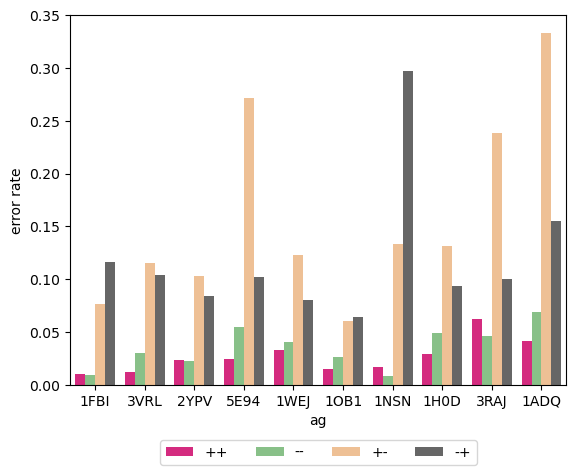

In [660]:
#vs9_acc_on_leak = model_mistakes_on_leak('vs 9', 0, 42)
plt.ylim([0,0.35])
sns.barplot(vs9_acc_on_leak, x='ag', y='error rate', hue='Type of leak', hue_order=['++', '--', '+-', '-+'], order=ag_order, palette={"++": "#F00F7F", "--": "#7FC97F","+-": "#FDC086","-+":"#666666"})
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.13), ncol=5)
plt.savefig("./figures/leak_error_vs9.svg")

In [561]:
df_test_leaked['correct pred'] = df_test_leaked['y_pred'] ==  df_test_leaked['y']


In [565]:
acc_on_leak = df_test_leaked.groupby('Type of leak').mean('correct pred')

In [568]:
acc_on_leak.reset_index()[['Type of leak', 'correct pred']]

,Type of leak,correct pred
0,++,0.998663
1,+-,0.916667
2,-+,1.000000
3,--,0.987952


In [559]:
df_test_leaked

,Unnamed: 0,sequence,y,Train,identifier,cluster,is_representative,Type of leak,X,y_pred
0,30000,AAFTYLRYFDV,1,False,30000,1729,False,++,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.0
1,30005,AALGLLRFLYF,1,False,30005,1454,False,++,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.0
2,30014,ACQLRLPFDYW,1,False,30014,1,False,++,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.0
3,30277,AQQLRLPFDYW,1,False,30277,1,False,++,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.0
4,30019,ADLLRFYAMDY,1,False,30019,0,False,++,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.0
...,...,...,...,...,...,...,...,...,...,...
937,39893,YTRFHWYFDVW,1,False,39893,340,False,++,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.0
938,39965,YYRFSYYFDYW,1,False,39965,1417,False,++,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.0
939,39991,YYYGSSSFDYW,0,False,39991,2025,False,--,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0
940,39997,YYYGTLLYFDV,1,False,39997,1505,False,++,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.0


In [ ]:
#Let's see models behave on "leak" sequences
seed = 0
TASK = 'HIGH_VS_95LOW'
model_path = f"./torch_models/Frozen_MiniAbsolut_ML/{tasks_dict[TASK]}/seed_{seed}/split_{split}/{task_template[TASK].format(ag=ag)}/swa_model/data/model.pth"
model = torch.load(model_path, map_location=torch.device('cpu'))

df_test_leaked['X'] = df_test_leaked.sequence.apply(onehot_encode)
X = torch.tensor(np.array(df_test_leaked['X'].tolist()), dtype=torch.float32).to('cpu')
y_pred = model(X, return_logits = False)
y_pred = y_pred.cpu().detach().numpy().reshape(-1).round()
df_test_leaked['y_pred'] = y_pred
pred_comp = df_test_leaked['y'] == df_test_leaked['y_pred']
df_test_leaked[~pred_comp]


In [324]:
ag = '1OB1'
task = 'vs Non-binder'
df = pd.read_csv(f'./cd-hit-res/{ag}__{task}__{split}.csv')

In [328]:
cluster_leaks, _ = cal_leaks(df)

In [331]:
cluster_leaks = pd.DataFrame([(key, val) for key, vals in cluster_leaks.items() for val in vals], columns=['Type of leak', 'cluster'])

In [335]:
df_stats_leaks = df_stats.sort_values('std', ascending=False).reset_index().merge(cluster_leaks, on='cluster', how='left')

In [346]:
df_stats_leaks['Type of leak'].iloc[0]

float

In [351]:
#change nan to non_leak
df_stats_leaks['Type of leak'] = df_stats_leaks['Type of leak'].fillna('no leak')

<AxesSubplot:xlabel='Type of leak', ylabel='std'>

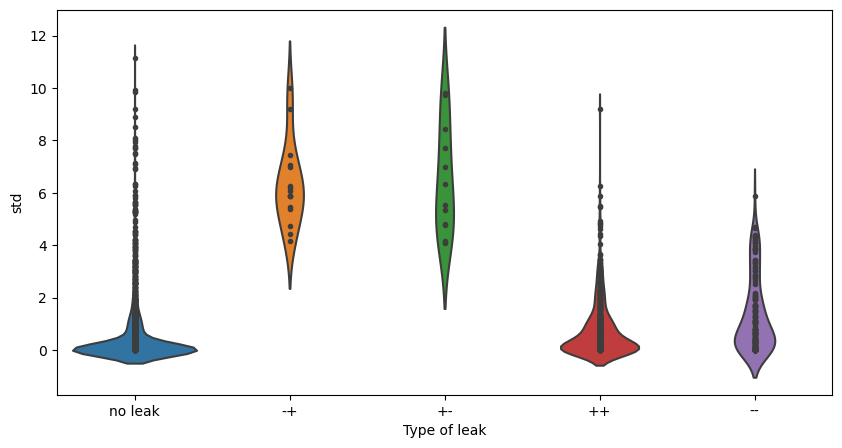

In [396]:
plt.figure(figsize=(10, 5))
sns.violinplot(df_stats_leaks, x='Type of leak', y='std', inner="points", figsize=(10,5))

In [355]:
cluster_leaks

,Type of leak,cluster
0,++,0
1,++,1
2,++,2
3,++,2049
4,++,4
...,...,...
867,-+,690
868,-+,825
869,-+,445
870,-+,542


In [357]:
#let's take the model and see if it make mistakes on leaked data
#find which slides in test are leaked, and what is the type of leak. Open test data
df_test_leaked = df[test].merge(cluster_leaks, on='cluster')

In [367]:
#find which slides in test are leaked, and what is the type of leak. Open test data
#df_test_leaked
seed = 0
TASK = 'HIGH_VS_95LOW'
model_path = f"./torch_models/Frozen_MiniAbsolut_ML/{tasks_dict[TASK]}/seed_{seed}/split_{split}/{task_template[TASK].format(ag=ag)}/swa_model/data/model.pth"
model = torch.load(model_path, map_location=torch.device('cpu'))

In [377]:
seed = 0
TASK = 'HIGH_VS_95LOW'
model_path = f"./torch_models/Frozen_MiniAbsolut_ML/{tasks_dict[TASK]}/seed_{seed}/split_{split}/{task_template[TASK].format(ag=ag)}/swa_model/data/model.pth"
model = torch.load(model_path, map_location=torch.device('cpu'))

df_test_leaked['X'] = df_test_leaked.sequence.apply(onehot_encode)
X = torch.tensor(np.array(df_test_leaked['X'].tolist()), dtype=torch.float32).to('cpu')
y_pred = model(X, return_logits = False)
y_pred = y_pred.cpu().detach().numpy().reshape(-1).round()
df_test_leaked['y_pred'] = y_pred
pred_comp = df_test_leaked['y'] == df_test_leaked['y_pred']
df_test_leaked[~pred_comp]


In [391]:
df_test_leaked[~pred_comp]
#we should calulate true and false pred on each type of leak

,Unnamed: 0,sequence,y,Train,identifier,cluster,is_representative,Type of leak,X,y_pred
351,34924,FDGYYVGFAYW,0,False,34924,600,False,--,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",1.0
416,35403,GGTLTFYFDYW,1,False,35403,513,False,++,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",0.0
770,38550,TGLLRLGAMDY,0,False,38550,1322,False,+-,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.0
841,39180,VTGLYWYFDVW,0,False,39180,1608,False,--,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.0


In [ ]:
#!!!make correlation of 'leak' and performance

In [ ]:
#when switching from train test
#pos that stayed pos
#neg that stayed negative
#pos that became negatives
#negatitives that became pos

#combine train test calculate

In [153]:
def binding_class_inters(ag, identity=0.9):
    #we go over all tasks and al possible seeds and splits
    int_dict = { 'vs 9':[],
                 'vs Non-binder':[],
                 'vs Weak':[]}
    for split in [0,1,2,3,4,42]:
        for task in tasks:
            try:
                df = get_train_test_data(ag, task, 0,split)
                df['fake_id'] = np.arange(df.shape[0])
                df = df.rename(columns={'fake_id': 'identifier','Slide':'sequence'})
                df['identifier'] = df.identifier.astype('str').values
                columns_to_keep = ['identifier',	'cluster', 'is_representative',	'identity']
                _, df_clstr = cdhit.set_options(c=identity, d=0, sc=1).cluster(df[['identifier', 'sequence']]) #writ here what parameters mean
                df = df.merge(df_clstr[columns_to_keep], on=['identifier'])
                pos_cl = df[df['y'] == 1].cluster.values
                neg_cl =df[df['y'] == 0].cluster.values
                cl_int = set(pos_cl).intersection(set(neg_cl))
                pos_cl_exl = set(pos_cl).difference(set(neg_cl))
                n_sc_dl = df[df['y'] == 0].cluster.isin(cl_int).sum()#same cluster, different label
                n_sc_pl = df[df['y'] == 1].cluster.isin(pos_cl_exl).sum() #same cluster, positive label
                p_label_change = n_sc_dl/(n_sc_dl+n_sc_pl)
                #interesting how much positive and negative intersect if 1 aa substitutions turns binder to nonbinder
                int_dict[task].append(p_label_change)
            except IndexError:
                print('No dataset with given characteristics')

    return int_dict

In [154]:
binding_class_inters('1ADQ')

{'vs 9': [0.016028851933480266,
  0.015941447764186885,
  0.015994785399117528,
  0.01582928417572509,
  0.014733887942267215,
  0.015381532140888821],
 'vs Non-binder': [0.0025529358762576963,
  0.002902902902902903,
  0.002552169343942351,
  0.0040058084222122075,
  0.004054662862291635,
  0.0026013006503251626],
 'vs Weak': [0.06197595716739065,
  0.05600121083699107,
  0.06384049944617863,
  0.0583963691376702,
  0.05801565261297652,
  0.058592174263816056]}

In [156]:
binding_class_inters('5E94')

{'vs 9': [0.02243638006324349,
  0.023027140922088997,
  0.026078234704112337,
  0.021248806952328326,
  0.02027094831911691,
  0.023122836936349502],
 'vs Non-binder': [0.0014507253626813406,
  0.0010005002501250625,
  0.0013512160944850365,
  0.0012510008006405124,
  0.0007501500300060011,
  0.0012005402431093993],
 'vs Weak': [0.08856633562515916,
  0.08589268490786334,
  0.08552297859389267,
  0.08820393033057432,
  0.08850007629316922,
  0.08589926590538335]}

In [ ]:
pos_cl = df[df['y'] == 1].cluster.values()
#neg_cl =df[df['y'] == 0].cluster.values()
#cl_int = set(pos_cl).intersection(set(neg_cl))
#pos_cl_exl = set(pos_cl).difference(set(neg_cl))

In [ ]:
n_sc_dl = df[df['y'] == 0].cluster.isin(cl_int).sum()#same cluster, different label
n_sc_pl = df[df['y'] == 1].cluster.isin(pos_cl_exl).sum() #same cluster, positive label
p_label_change = n_sc_dl/(n_sc_dl+n_sc_pl)
#interesting how much positive and negative intersect if 1 aa substitutions turns binder to nonbinder
int_dict[task].append(p_label_change)

In [113]:
dfs = []
for ag in config.ANTIGENS:
   leak = data_leak_cd_hit(ag) 
   df = pd.DataFrame(leak).melt(var_name='class')
   df['Antigen'] = [ag]*df.shape[0]
   dfs.append(df)

In [114]:
df_leaks = pd.concat(dfs)

In [115]:
cmap = { 'vs 9' : '#FF5733',
         'vs Non-binder':'#00A6ED',
         'vs Weak':'#FFC300',
         'vs 1': '#8B5F4D',
         'pos': '#808080'}

<AxesSubplot:xlabel='Antigen', ylabel='value'>

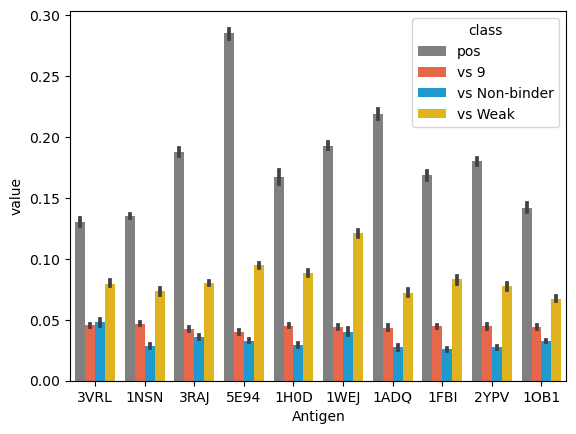

In [116]:
#normalized to number of clusters in test only
sns.barplot(x='Antigen',y='value',hue='class',data=df_leaks, palette=cmap)
#sns.stripplot(x='Antigen',y='value',hue='class',data=df_leaks, alpha=0.8, jitter=True, dodge=True,)
#we have significant data leakage ...

In [ ]:
#how many sequences 
#how often labels of the same cluster can be different?


,Slide,X,y,Train,fake_id
0,AAFYGRWYFDV,[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,1,True,0
1,AAFYYGNLAWF,[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,1,True,1
2,AAGLLRFAWFA,[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,0,True,2
3,AAGLLRLYYYA,[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,0,True,3
4,AAIFITTGGFD,[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,1,True,4
...,...,...,...,...,...
9990,YYYGSSFYVLF,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,0,False,39984
9991,YYYGSSLTLFA,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,0,False,39985
9992,YYYGSSPFLFA,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,1,False,39986
9993,YYYGSSYLLLA,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,1,False,39987


<AxesSubplot:xlabel='Antigen', ylabel='value'>

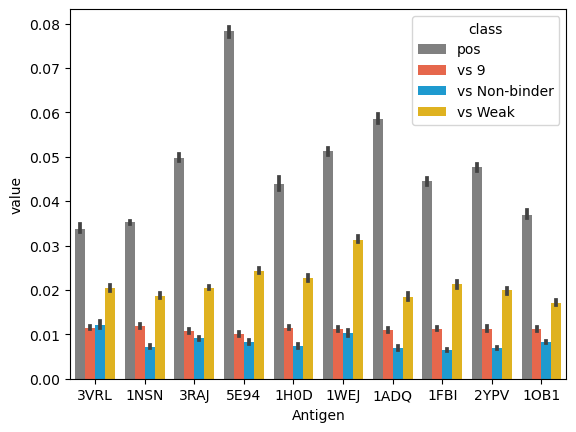

In [111]:
#normalized to number of clusters in train and test
sns.barplot(x='Antigen',y='value',hue='class',data=df_leaks, palette=cmap)
#sns.stripplot(x='Antigen',y='value',hue='class',data=df_leaks, alpha=0.8, jitter=True, dodge=True,)

In [ ]:
#I have to consider not only the number of intersect sequences, but also the number of sequences in this test_dataset
